[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Class Distribution:
label
0    4825
1     747
Name: count, dtype: int64


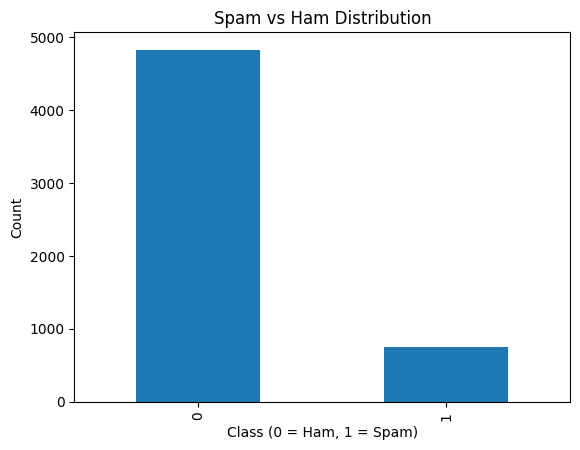

In [1]:
# Import required libraries for data handling, text processing, and ML
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download English stopwords for text preprocessing
nltk.download('stopwords')

# Load the dataset from the given Colab path
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

# Keep only the required columns and rename them for clarity
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

# Convert text labels into numeric form (spam=1, ham=0) for ML models
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Load stopwords list for cleaning the text
stop_words = set(stopwords.words('english'))

# Function to clean and normalize the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation symbols and numbers
    text = re.sub(f"[{string.punctuation}0-9]", " ", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove common stopwords like 'the', 'is', 'and'
    words = text.split()
    words = [w for w in words if w not in stop_words]

    # Return cleaned text
    return " ".join(words)

# Apply text cleaning to the dataset
df['cleaned_text'] = df['text'].apply(clean_text)

# Convert text data into numerical TF-IDF features for model input
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Print class distribution to check dataset balance
print("Class Distribution:")
print(df['label'].value_counts())

# Visualize class distribution using a bar chart
plt.figure()
df['label'].value_counts().plot(kind='bar')
plt.title("Spam vs Ham Distribution")
plt.xlabel("Class (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()


Train Accuracy: 0.8849001570563159
Test Accuracy: 0.8959641255605382
Confusion Matrix:
 [[930  36]
 [ 80  69]]


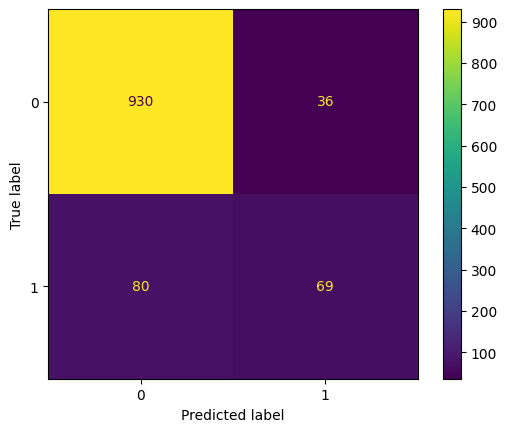


Comment:
Decision stumps are weak learners because they split data using only one feature.
Text data is high-dimensional and complex, so a single split cannot capture useful patterns.
Hence, performance on text classification tasks like spam detection is generally poor.


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize a Decision Tree with max_depth = 1 (Decision Stump)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)

# Train the model on training data
stump.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

# Calculate train and test accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Comment on weak performance
print("\nComment:")
print("Decision stumps are weak learners because they split data using only one feature.")
print("Text data is high-dimensional and complex, so a single split cannot capture useful patterns.")
print("Hence, performance on text classification tasks like spam detection is generally poor.")



Iteration 1
Misclassified indices: [14, 42, 49, 50, 59, 62, 86, 96, 100, 103, 115, 121, 140, 142, 157, 162, 194, 195, 196, 203, 224, 263, 294, 295, 300, 302, 321, 327, 343, 344, 351, 352, 361, 369, 370, 389, 395, 404, 408, 417, 429, 446, 449, 458, 460, 461, 472, 477, 478, 486, 500, 501, 512, 513, 514, 533, 542, 544, 559, 580, 591, 596, 614, 623, 626, 647, 674, 677, 679, 690, 716, 732, 733, 743, 744, 750, 768, 769, 777, 781, 788, 790, 802, 803, 838, 845, 867, 870, 882, 884, 900, 907, 922, 927, 930, 955, 964, 969, 970, 972, 974, 978, 1010, 1013, 1016, 1036, 1046, 1047, 1067, 1080, 1098, 1100, 1103, 1112, 1114, 1132, 1177, 1179, 1214, 1218, 1223, 1238, 1242, 1246, 1281, 1292, 1293, 1294, 1297, 1299, 1309, 1314, 1315, 1326, 1329, 1332, 1346, 1357, 1364, 1365, 1374, 1379, 1390, 1414, 1435, 1452, 1453, 1455, 1458, 1468, 1469, 1473, 1481, 1482, 1495, 1498, 1512, 1519, 1533, 1541, 1556, 1561, 1570, 1597, 1602, 1613, 1627, 1646, 1650, 1658, 1677, 1683, 1698, 1709, 1710, 1711, 1716, 1725, 1731,

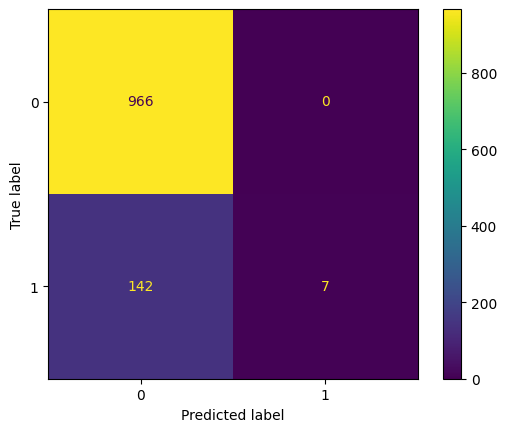

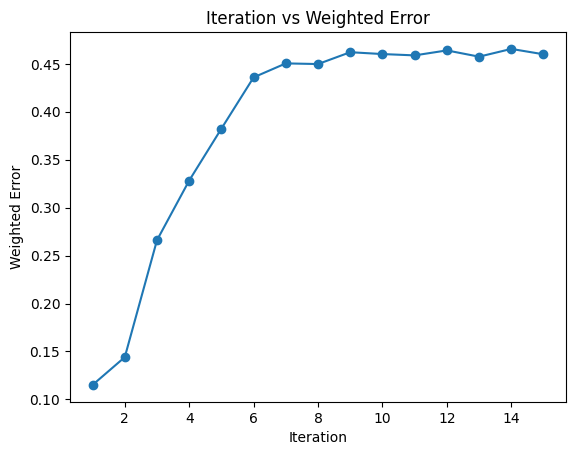

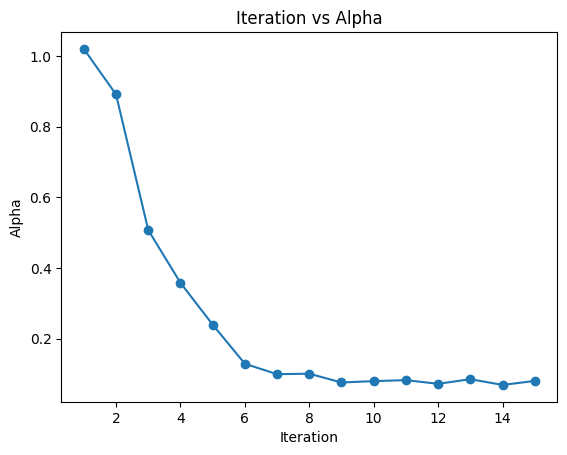


Interpretation:
Initially, all samples have equal weights.
After each iteration, misclassified samples receive higher weights.
This forces the next weak learner to focus more on difficult examples.
Over iterations, the model increasingly emphasizes hard-to-classify messages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Number of boosting rounds
T = 15
n = X_train.shape[0]

# Initialize sample weights uniformly
weights = np.ones(n) / n

# Lists to store alphas, errors, and models
alphas = []
errors = []
models = []

for t in range(T):
    # Train weak learner (decision stump) with current sample weights
    model = DecisionTreeClassifier(max_depth=1, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)

    # Predict on training data
    y_pred = model.predict(X_train)

    # Identify misclassified samples
    incorrect = (y_pred != y_train)
    misclassified_indices = np.where(incorrect)[0]

    # Compute weighted error
    error = np.sum(weights[incorrect])

    # Avoid division by zero
    error = max(error, 1e-10)

    # Compute alpha (model weight)
    alpha = 0.5 * np.log((1 - error) / error)

    # Print iteration details
    print(f"\nIteration {t+1}")
    print("Misclassified indices:", misclassified_indices.tolist())
    print("Weights of misclassified samples:", weights[incorrect])
    print("Alpha:", alpha)

    # Update weights
    weights *= np.exp(-alpha * y_train * (2*y_pred - 1))
    weights /= np.sum(weights)  # Normalize

    # Store values
    alphas.append(alpha)
    errors.append(error)
    models.append(model)

# Function to make AdaBoost predictions
def adaboost_predict(X):
    weighted_preds = np.zeros(X.shape[0])

    for alpha, model in zip(alphas, models):
        pred = model.predict(X)
        pred = (2 * pred) - 1  # Convert 0/1 to -1/+1
        weighted_preds += alpha * pred

    return (weighted_preds > 0).astype(int)

# Predictions for train and test data
y_train_pred = adaboost_predict(X_train)
y_test_pred = adaboost_predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nFinal Train Accuracy:", train_acc)
print("Final Test Accuracy:", test_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Plot iteration vs weighted error
plt.figure()
plt.plot(range(1, T+1), errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

# Plot iteration vs alpha
plt.figure()
plt.plot(range(1, T+1), alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

# Short interpretation of weight evolution
print("\nInterpretation:")
print("Initially, all samples have equal weights.")
print("After each iteration, misclassified samples receive higher weights.")
print("This forces the next weak learner to focus more on difficult examples.")
print("Over iterations, the model increasingly emphasizes hard-to-classify messages.")



Iteration 1
Misclassified indices: [14, 42, 49, 50, 59, 62, 86, 96, 100, 103, 115, 121, 140, 142, 157, 162, 194, 195, 196, 203, 224, 263, 294, 295, 300, 302, 321, 327, 343, 344, 351, 352, 361, 369, 370, 389, 395, 404, 408, 417, 429, 446, 449, 458, 460, 461, 472, 477, 478, 486, 500, 501, 512, 513, 514, 533, 542, 544, 559, 580, 591, 596, 614, 623, 626, 647, 674, 677, 679, 690, 716, 732, 733, 743, 744, 750, 768, 769, 777, 781, 788, 790, 802, 803, 838, 845, 867, 870, 882, 884, 900, 907, 922, 927, 930, 955, 964, 969, 970, 972, 974, 978, 1010, 1013, 1016, 1036, 1046, 1047, 1067, 1080, 1098, 1100, 1103, 1112, 1114, 1132, 1177, 1179, 1214, 1218, 1223, 1238, 1242, 1246, 1281, 1292, 1293, 1294, 1297, 1299, 1309, 1314, 1315, 1326, 1329, 1332, 1346, 1357, 1364, 1365, 1374, 1379, 1390, 1414, 1435, 1452, 1453, 1455, 1458, 1468, 1469, 1473, 1481, 1482, 1495, 1498, 1512, 1519, 1533, 1541, 1556, 1561, 1570, 1597, 1602, 1613, 1627, 1646, 1650, 1658, 1677, 1683, 1698, 1709, 1710, 1711, 1716, 1725, 1731,

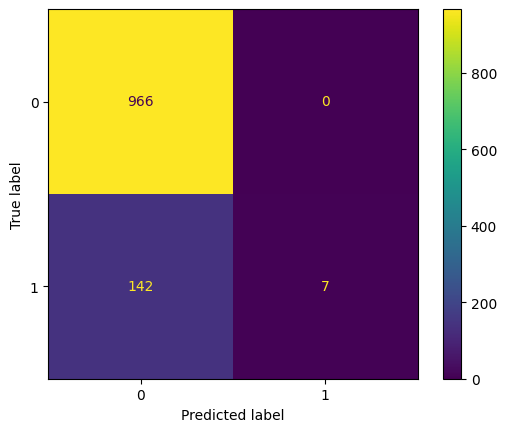

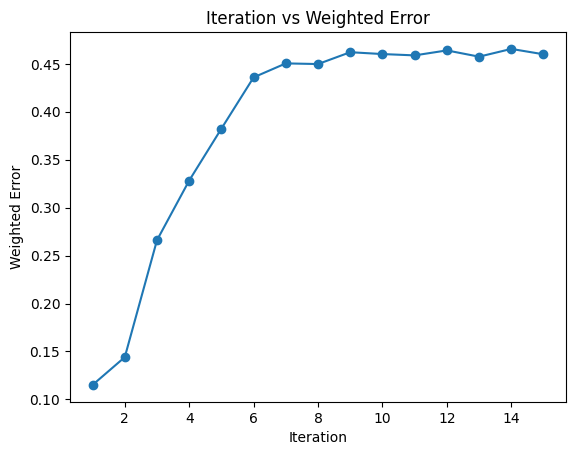

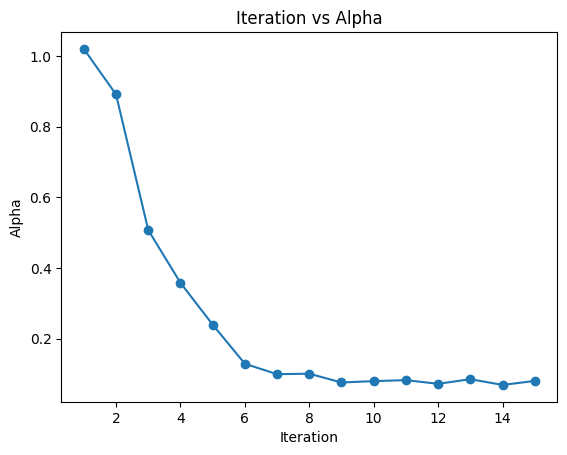


Interpretation:
Initially, all samples have equal weights.
After each iteration, misclassified samples receive higher weights.
This forces the next weak learner to focus more on difficult examples.
Over iterations, the model increasingly emphasizes hard-to-classify messages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Number of boosting rounds
T = 15
n = X_train.shape[0]

# Initialize sample weights uniformly
weights = np.ones(n) / n

# Lists to store alphas, errors, and models
alphas = []
errors = []
models = []

for t in range(T):
    # Train weak learner (decision stump) with current sample weights
    model = DecisionTreeClassifier(max_depth=1, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)

    # Predict on training data
    y_pred = model.predict(X_train)

    # Identify misclassified samples
    incorrect = (y_pred != y_train)
    misclassified_indices = np.where(incorrect)[0]

    # Compute weighted error
    error = np.sum(weights[incorrect])

    # Avoid division by zero
    error = max(error, 1e-10)

    # Compute alpha (model weight)
    alpha = 0.5 * np.log((1 - error) / error)

    # Print iteration details
    print(f"\nIteration {t+1}")
    print("Misclassified indices:", misclassified_indices.tolist())
    print("Weights of misclassified samples:", weights[incorrect])
    print("Alpha:", alpha)

    # Update weights
    weights *= np.exp(-alpha * y_train * (2*y_pred - 1))
    weights /= np.sum(weights)  # Normalize

    # Store values
    alphas.append(alpha)
    errors.append(error)
    models.append(model)

# Function to make AdaBoost predictions
def adaboost_predict(X):
    weighted_preds = np.zeros(X.shape[0])

    for alpha, model in zip(alphas, models):
        pred = model.predict(X)
        pred = (2 * pred) - 1  # Convert 0/1 to -1/+1
        weighted_preds += alpha * pred

    return (weighted_preds > 0).astype(int)

# Predictions for train and test data
y_train_pred = adaboost_predict(X_train)
y_test_pred = adaboost_predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nFinal Train Accuracy:", train_acc)
print("Final Test Accuracy:", test_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Plot iteration vs weighted error
plt.figure()
plt.plot(range(1, T+1), errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

# Plot iteration vs alpha
plt.figure()
plt.plot(range(1, T+1), alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

# Short interpretation of weight evolution
print("\nInterpretation:")
print("Initially, all samples have equal weights.")
print("After each iteration, misclassified samples receive higher weights.")
print("This forces the next weak learner to focus more on difficult examples.")
print("Over iterations, the model increasingly emphasizes hard-to-classify messages.")
